In [0]:
import requests
import pandas as pd
import numpy as np
from datetime import date, timedelta

import matplotlib.pyplot as plt
import json

from pyspark.sql.functions import col, when, lit, udf
from pyspark.sql.types import DoubleType

from pyspark.ml.feature import VectorAssembler, StandardScalerModel
from pyspark.ml.clustering import KMeansModel

import math

##Utility functions

In [0]:
 def train_kmeans_model(df, k, features_col):
    # Trains a k-means model.
    # Inspired by https://spark.apache.org/docs/latest/ml-clustering.html
    kmeans = KMeans().setK(k).setSeed(1)
    kmeans.setFeaturesCol(features_col) # Set custom feature vector col
    model = kmeans.fit(df)
    return model

def compute_distance(point, cluster_id):
    # Function to compute distance between a point and its cluster centroid - "centers" needs to be callable
    center = centers[cluster_id]
    return float(math.sqrt(sum((p - c)**2 for p, c in zip(point, center))))

## Loading pretrained models

In [0]:
# Load from saved path
kmeans_model = KMeansModel.load("/dbfs/tmp/kmeans_model")
scaler_model = StandardScalerModel.load("/dbfs/tmp/scaler_model")

# Load kmenas distance threshold
distance_threshold_json = dbutils.fs.head("dbfs:/tmp/kmeans_distance_threshold.json")
distance_threshold = json.loads(distance_threshold_json)

## Streaming simulation - Data input

In [0]:
feature_cols = [
    "temperature_2m", "precipitation", "wind_speed_10m",
    "wind_speed_80m", "wind_speed_120m", "wind_speed_180m",
    "cloud_cover"
]

In [0]:
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 38.716885,
    "longitude": -9.140233,
    "hourly": feature_cols,
    "forecast_days": 7
}

response = requests.get(url, params=params)
data = response.json()
forecast_df = pd.DataFrame(data['hourly'])

In [0]:
forecast_df

,time,temperature_2m,precipitation,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,cloud_cover
0,2025-05-16T00:00,14.1,0.0,2.7,9.9,12.7,23.1,20
1,2025-05-16T01:00,13.7,0.0,2.9,7.4,11.1,18.8,2
2,2025-05-16T02:00,13.1,0.0,3.7,6.7,10.6,17.0,26
3,2025-05-16T03:00,12.8,0.0,3.2,7.1,11.9,18.9,100
4,2025-05-16T04:00,12.7,0.0,1.8,5.8,10.4,16.6,100
...,...,...,...,...,...,...,...,...
163,2025-05-22T19:00,25.2,0.0,19.5,30.9,33.5,38.4,0
164,2025-05-22T20:00,23.6,0.0,17.0,27.2,31.2,41.2,0
165,2025-05-22T21:00,22.4,0.0,14.5,23.7,28.3,41.7,0
166,2025-05-22T22:00,21.8,0.0,12.4,21.1,25.7,38.9,0


#### Fake anomaly day

In [0]:
# Convert time column to datetime
forecast_df["time"] = pd.to_datetime(forecast_df["time"])

# Extract the last 24 hours
last_24h = forecast_df.tail(24).copy()

# Temp increase
temp_start_increase = 5.0
temp_end_increase = 25.0
increments = np.linspace(temp_start_increase, temp_end_increase, 24)

# Shift time + apply temperature increase
new_rows = []
for i, row in last_24h.iterrows():
    new_row = row.copy()
    new_row["time"] = row["time"] + timedelta(days=1)
    new_row["temperature_2m"] = row["temperature_2m"] + increments[i - last_24h.index[0]]
    new_rows.append(new_row)

# Append the new synthetic rows
forecast_df = pd.concat([forecast_df, pd.DataFrame(new_rows)], ignore_index=True)

In [0]:
forecast_df

,time,temperature_2m,precipitation,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,cloud_cover
0,2025-05-16 00:00:00,14.100000,0.0,2.7,9.9,12.7,23.1,20
1,2025-05-16 01:00:00,13.700000,0.0,2.9,7.4,11.1,18.8,2
2,2025-05-16 02:00:00,13.100000,0.0,3.7,6.7,10.6,17.0,26
3,2025-05-16 03:00:00,12.800000,0.0,3.2,7.1,11.9,18.9,100
4,2025-05-16 04:00:00,12.700000,0.0,1.8,5.8,10.4,16.6,100
...,...,...,...,...,...,...,...,...
187,2025-05-23 19:00:00,46.721739,0.0,19.5,30.9,33.5,38.4,0
188,2025-05-23 20:00:00,45.991304,0.0,17.0,27.2,31.2,41.2,0
189,2025-05-23 21:00:00,45.660870,0.0,14.5,23.7,28.3,41.7,0
190,2025-05-23 22:00:00,45.930435,0.0,12.4,21.1,25.7,38.9,0


### Spark DF -  Scaling

In [0]:
forecast_sdf = spark.createDataFrame(forecast_df)

# Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_sdf = assembler.transform(forecast_sdf)

# Load saved scaler model from training notebook
scaler_model = StandardScalerModel.load("/dbfs/tmp/scaler_model")
scaled_sdf = scaler_model.transform(assembled_sdf)

### Kmeans model load and clustering of forecast

In [0]:
# Load saved kmeans model from training notebook
model = KMeansModel.load("/dbfs/tmp/kmeans_model")

# Get cluster centers for outlier detection
centers = model.clusterCenters()

# Distance user defined function - using compute distance utility function defined above
distance_udf = udf(compute_distance, DoubleType())

# Apply model
predicted_sdf = model.transform(scaled_sdf)

# apply distance udf to all points
scored_sdf = predicted_sdf.withColumn(
    "distance_cluster_center",
    distance_udf(col("features_scaled"), col("prediction"))
)

# Detect anomalies based on distance threshold
scored_sdf = scored_sdf.withColumn(
    "is_anomaly",
    when(col("distance_cluster_center") > distance_threshold, 1).otherwise(0) # Distance threshold loaded above
)

### Visualização
Done through matplotlib / pandas as we're only looking at small data (~1 week)

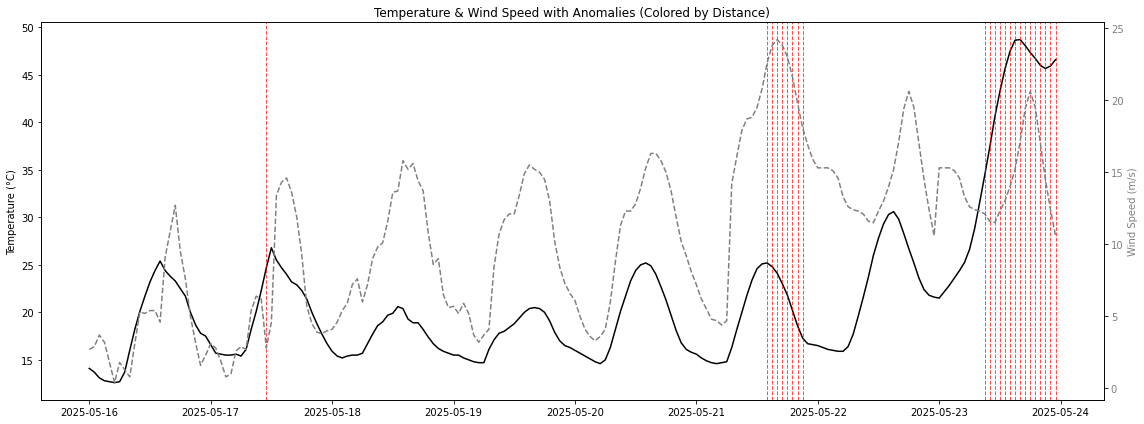

In [0]:
# Selection of relevant columns and conversion to pandas for visualization
plot_df = scored_sdf.select(
    "time",
    "temperature_2m",
    "wind_speed_10m",
    "distance_cluster_center",
    "is_anomaly"
).orderBy("time").toPandas()

fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot temperature as a line
ax1.plot(plot_df["time"], plot_df["temperature_2m"], color="black", label="Temperature (°C)")
ax1.set_ylabel("Temperature (°C)", color="black")
ax1.tick_params(axis='y', labelcolor="black")

# Overlay anomalies
for anomaly_time in plot_df.loc[plot_df["is_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Secondary axis for wind speed
ax2 = ax1.twinx()
ax2.plot(plot_df["time"], plot_df["wind_speed_10m"], color="gray", linestyle='--', label="Wind Speed (10m)")
ax2.set_ylabel("Wind Speed (m/s)", color="gray")
ax2.tick_params(axis='y', labelcolor="gray")

# Title and legend
plt.title("Temperature & Wind Speed with Anomalies")
fig.tight_layout()
plt.show()